# Losses

Common losses that are used in classification, object detection and pixel-wise segmentation.

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

## Focal Loss

Focal loss aims to solve class imbalance problem which happens a lot in computer vision. For example, in pixel-wise segmentation, majority of the pixels are considered negative examples, meaning no objects.

In [63]:
p = np.random.uniform(low=0, high=1, size=(10,))
y = np.zeros(10) # Dominated by 0s
y[0] = 1
print(f"Predictions: \n\t{np.round(p, 2)}")
print(f"Ground Truths:\n\t{y}")

Predictions: 
	[0.04 0.65 0.64 0.29 0.92 0.31 0.39 0.89 0.5  0.13]
Ground Truths:
	[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Start from a simple cross entropy loss

$$
\begin{equation}
    \text{Cross Entropy Loss}(p, y) = 
    \begin{cases}
        -log(p), & \text{if} \ y=1 \\
        -log(1-p), & \text{otherwise}
    \end{cases}
\end{equation}
$$

In [64]:
def cross_entropy_loss(p: np.ndarray, y: np.ndarray):
    """Not numerically stable, it can divide by 0"""
    assert p.shape == y.shape
    losses = np.zeros(len(p))
    losses[y == 1] = -np.log(p[y == 1])
    losses[y == 0] = -np.log(1 - p[y == 0])
    return losses

In [65]:

print("Sum of cross entropy losses from random examples", cross_entropy_loss(p, y).sum())
print("Sum of cross entropy losses from all correct predictions", cross_entropy_loss(y, y).sum())

Sum of cross entropy losses from random examples 12.247943157454628
Sum of cross entropy losses from all correct predictions 0.0


Let

$$
\begin{equation}
    p_t = 
    \begin{cases}
        p, & \text{if} \ y=1 \\
        1-p, & \text{otherwise}
    \end{cases}
\end{equation}
$$

The $\alpha_t$ is a weighted hyperparameter term. Higher alpha means positive examples contribute more to the loss. If alpha is 1, negative examples don't contribute any to the loss. It gives high weights to the rare class and small weights to the dominating or common class.

- $\alpha$ for positive class
- $1 - \alpha$ for negative class

The $\gamma$ is another hyperparameter that controls the shape of the loss curve. The higher value of $\gamma$, the lower the loss for well-classified examples, so we could turn the attention of the model more towards hard-to-classify examples. Having high $\gamma$ extends the range in which an example receives low loss.

$$
\begin{equation}
    \text{Focal Loss}(p, y) = 
    \begin{cases}
        -\alpha(1 - p)^{\gamma}log(p), & \text{if} \ y=1 \\
        -(1 - \alpha)p^{\gamma}log(1-p), & \text{otherwise}
    \end{cases}
\end{equation}
$$

In [66]:
def focal_loss(p: np.ndarray, y: np.ndarray, alpha: float, gamma: float):
    assert p.shape == y.shape
    losses = np.zeros(len(p))
    losses[y == 1] = -alpha * (1 - p[y == 1])**gamma * np.log(p[y == 1])
    losses[y == 0] = -(1 - alpha)*p[y == 0]**gamma * np.log(1 - p[y == 0])
    return losses

In [75]:
print("Sum of focal losses from random examples", focal_loss(p, y, alpha=1, gamma=2).sum())
print("Sum of focal losses from all correct predictions", focal_loss(y, y, alpha=1, gamma=2).sum())

Sum of focal losses from random examples 3.082773304810852
Sum of focal losses from all correct predictions 0.0


### Effect of Alpha

When `alpha=1`:

In [76]:
print("Notice that only mis-classifcation of positive examples contributes to loss\n\t",
      np.round(focal_loss(p, y, alpha=1, gamma=0), 2))

Notice that only misclassifcation of positive examples contributes to loss
	 [ 3.32 -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.   -0.  ]


When `alpha=0`:

In [78]:
print("Notice that only mis-classifcation of negative examples contributes to loss\n\t",
      np.round(focal_loss(p, y, alpha=0, gamma=0), 2))

Notice that only mis-classifcation of negative examples contributes to loss
	 [-0.    1.05  1.03  0.34  2.58  0.37  0.49  2.23  0.69  0.14]


### Effect of Gamma

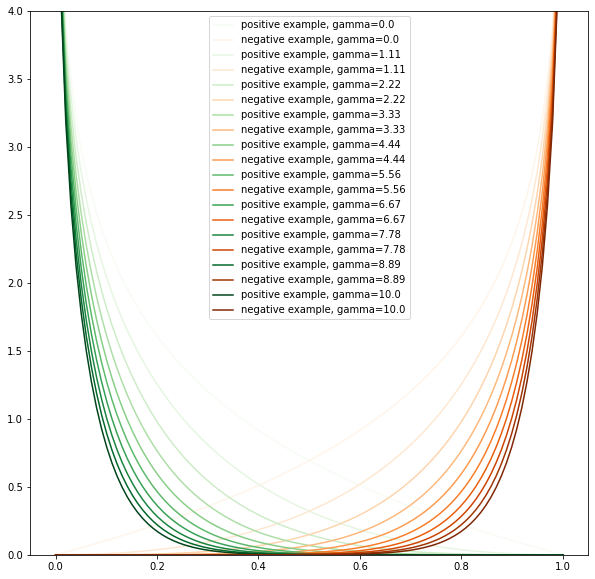

In [105]:
fig, ax = plt.subplots(1, figsize=(10, 10))
positives = np.ones(100)
negatives = np.zeros(100)
p = np.linspace(1e-5, 1-1e-5, 100)

greens = plt.cm.get_cmap('Greens')(np.linspace(0, 1, 10))
oranges = plt.cm.get_cmap('Oranges')(np.linspace(0, 1, 10))
for i, gamma in enumerate(np.linspace(0, 10, 10)):
    ax.plot(p, focal_loss(p, positives, alpha=1, gamma=gamma),
            color=greens[i],
            label=f"positive example, gamma={np.round(gamma, 2)}")
    ax.plot(p, focal_loss(p, negatives, alpha=0, gamma=gamma),
            color=oranges[i],
            label=f"negative example, gamma={np.round(gamma, 2)}")
ax.legend(loc='upper center')
ax.set_ylim(0, 4)
plt.show()